In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

In [5]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

cuda


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5)
    )
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


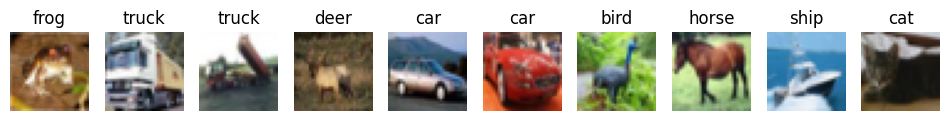

In [5]:
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    image = train_loader.dataset[i][0].permute(1, 2, 0)
    denormalized_image= image / 2 + 0.5
    axes[i].imshow(denormalized_image)
    axes[i].set_title(classes[train_loader.dataset[i][1]])
    axes[i].axis('off')
plt.show()


In [30]:
class ConvNeuralNet(nn.Module):
    def __init__(self, in_channels = 3, num_classes = 10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)

        self.pool = nn.MaxPool2d(2, stride=2)

        self.fc1 = nn.Linear(128 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

net = ConvNeuralNet()
net.to(device)

for name, param in net.named_parameters():
    if "conv" in name:
        param.requires_grad = False


In [36]:
conv1_output = None

def hook_fn(module, input, output):
    global conv1_output
    conv1_output = output  # Store output of conv1

hook = net.conv1.register_forward_hook(hook_fn)

In [37]:
loss_function = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

epochs = 1
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}/{epochs}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
print(conv1_output)


[1/1,  2000] loss: 0.971
[1/1,  4000] loss: 0.977
[1/1,  6000] loss: 0.948
[1/1,  8000] loss: 0.959
[1/1, 10000] loss: 0.975
[1/1, 12000] loss: 0.983
Finished Training
tensor([[[[-1.2183e-02, -2.2245e-01, -3.7540e-01,  ..., -3.9974e-02,
           -8.6300e-02, -9.2922e-02],
          [-1.1850e-01, -2.8074e-01, -3.1800e-01,  ..., -2.5850e-01,
           -3.5560e-01, -3.4983e-01],
          [-2.5378e-01, -3.3373e-01, -1.9975e-01,  ..., -4.2921e-01,
           -4.5636e-01, -4.4311e-01],
          ...,
          [-1.5214e-01, -1.7369e-01, -1.7977e-01,  ...,  2.3417e-02,
            3.0581e-02, -3.1296e-02],
          [-1.8961e-01, -8.3463e-02, -7.9109e-02,  ..., -6.5551e-04,
           -1.4566e-02, -4.8562e-02],
          [-1.4393e-01, -1.9769e-01, -2.2287e-01,  ..., -3.4722e-02,
           -7.3592e-02, -1.0528e-01]],

         [[-1.7378e-02, -5.8445e-02, -1.3900e-01,  ...,  4.2699e-03,
           -4.8239e-03, -1.2787e-01],
          [-2.2291e-02, -1.0925e-01, -1.2280e-01,  ..., -3.0379e-0

In [10]:
def view_classification(image, probabilities):
    probabilities = probabilities.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)

    image = image.permute(1, 2, 0)
    denormalized_image= image / 2 + 0.5
    ax1.imshow(denormalized_image)
    ax1.axis('off')
    ax2.barh(np.arange(10), probabilities)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    plt.show()

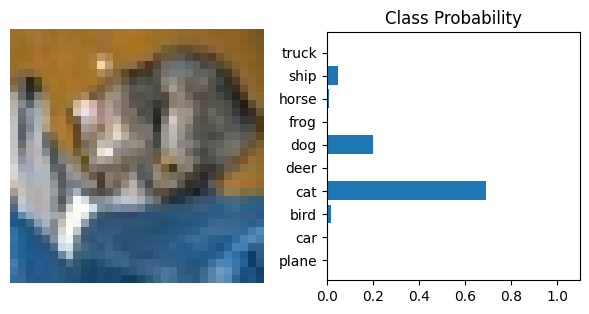

In [32]:
images, _ = next(iter(test_loader))

image = images[0]
batched_image = image.unsqueeze(0).to(device)
with torch.no_grad():
    log_probabilities = net(batched_image)

probabilities = torch.exp(log_probabilities).squeeze().cpu()
view_classification(image, probabilities)

In [33]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 60 %
